Inicjalizacja zadania

In [1]:
# Import bibliotek
import regex as reg
import operator
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import chain

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar -xvf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install ipinfo
!pip install cartopy
!pip install basemap

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession
import cartopy.crs as crs
import ipinfo
from mpl_toolkits.basemap import Basemap


spark-3.1.2-bin-hadoop3.2/
spark-3.1.2-bin-hadoop3.2/R/
spark-3.1.2-bin-hadoop3.2/R/lib/
spark-3.1.2-bin-hadoop3.2/R/lib/sparkr.zip
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/worker.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/worker/daemon.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/shell.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/profile/general.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.html
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.Rmd
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/sparkr-vignettes.R
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/doc/index.html
spark-3.1.2-bin-hadoop3.2/R/lib/SparkR/R/
spark-3.1.2-

In [3]:
# spark
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
spark

In [4]:
urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")

('apache_logs', <http.client.HTTPMessage at 0x7f3fb486ae10>)

**Zadanie nr 1**

In [5]:
# Tworzymy RDD
data = sc.textFile("apache_logs")

data.collect()[:25]

['83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.149.9.216 - - [17/May/2015:10:05:43 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-dashboard3.png HTTP/1.1" 200 171717 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.149.9.216 - - [17/May/2015:10:05:47 +0000] "GET /presentations/logstash-monitorama-2013/plugin/highlight/highlight.js HTTP/1.1" 200 26185 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.

1. Narysować wykres (pie chart) popularności przeglądarek.


In [6]:
browsers = [
    'Google Chrome',
    'Chrome',
    'Internet Explorer',
    'Mozilla Firefox',
    'Mozilla',
    'Safari',
    'Opera',
    'Konqueror',
    'Lynx',
    ]

def find_browser(log):
  browser_regex = r"\"(\w+(?=/\d+\.\d+))"
  result = reg.findall(browser_regex, log)
  if len(result) > 0 and result[0] in browsers:
    return result[0]
  else:
    None

In [7]:
top_k = 10
 
 
browser_counts = (data
    .map(lambda log: (find_browser(log), 1))
    .filter(lambda x: x[0] != None)
    .reduceByKey(operator.add)
    # x = (link, count)
    .takeOrdered(top_k, lambda x: x[1])
)
 
browser_counts

[('Lynx', 1), ('Safari', 34), ('Opera', 89), ('Mozilla', 8382)]

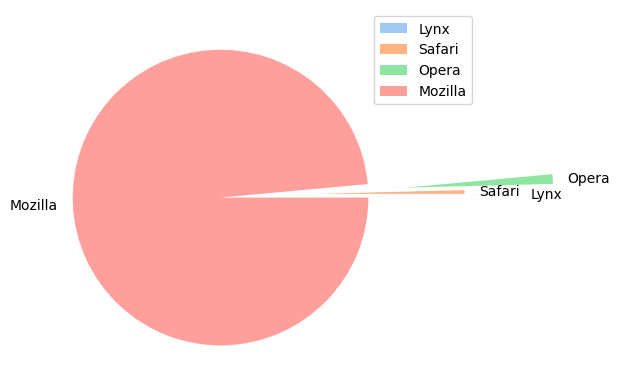

In [8]:
y = [browser_counts[i][1] for i in range(len(browser_counts))]
x = [browser_counts[i][0] for i in range(len(browser_counts))]
myexplode = [0.5, 0.15, 0.75, 0.5]


colors = sns.color_palette('pastel')[0:5]
plt.pie(y, labels = x, colors=colors, explode = myexplode)
plt.legend()
plt.show()

2. Narysować wykres słupkowy liczby wywołań (request) na godzinę w zależności od czasu, pogrupowane po kodzie odpowiedzi (200, 404, etc).


In [9]:
pattern_hour = "\[\d+/\w+/\d+:(\d+):"
pattern_code = "\"(GET|HEAD|POST|OPTIONS).*?\" (\d+)"

def get_hour_and_code(log):
  hour = int(reg.search(pattern_hour, log).group(1))
  code = int(reg.search(pattern_code, log).group(2))

  return (hour, code), 1

In [10]:
requests_counts = (data
  .map(lambda log: get_hour_and_code(log))
  .reduceByKey(operator.add)
  # x[0] = (hour, response_code), x[1] = count
  .map(lambda x: [x[0][0], x[0][1], x[1]])
  .collect()
)

for requests_count in requests_counts[:10]:
    print(requests_count)

[10, 200, 418]
[10, 404, 11]
[11, 301, 2]
[12, 200, 418]
[12, 304, 8]
[13, 301, 20]
[14, 206, 1]
[14, 200, 445]
[16, 200, 453]
[16, 304, 8]


In [11]:
df = pd.DataFrame(
    data=requests_counts,
    columns=["hour", "code", "count"]
)
df

,hour,code,count
0,10,200,418
1,10,404,11
2,11,301,2
3,12,200,418
4,12,304,8
...,...,...,...
101,3,304,3
102,8,301,1
103,19,206,16
104,3,206,2


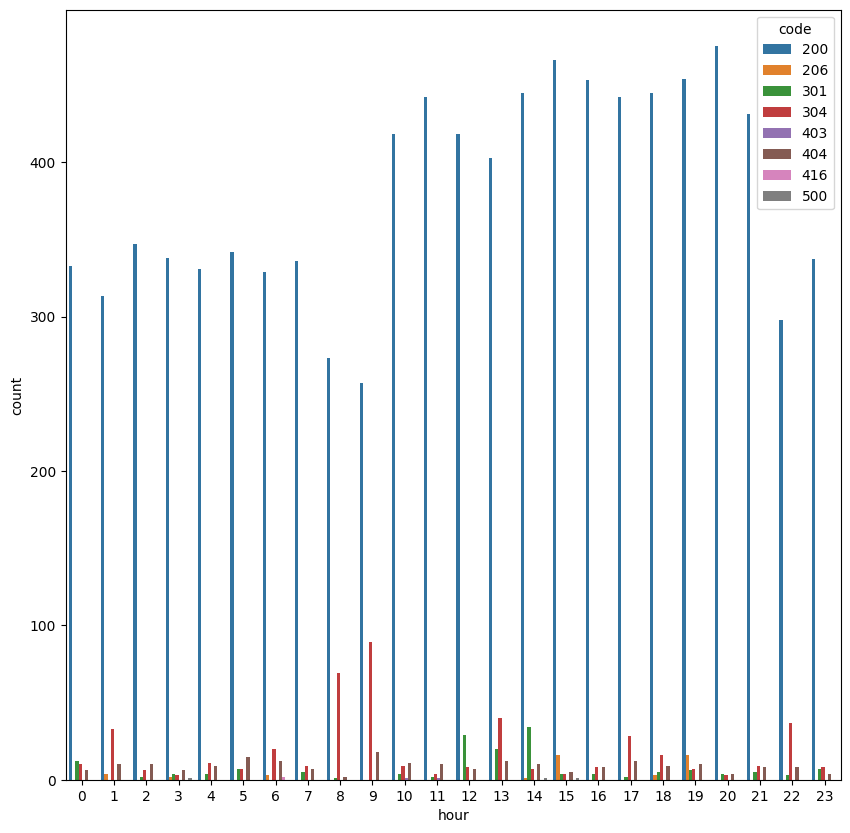

In [12]:
plt.figure(figsize=[10, 10])
sns.barplot(data=df, x="hour", y="count", hue="code")
plt.show()

3. Narysować wykres rankingu pobieranych zasobów według typów plików (html, css, png, etc.).

In [13]:
pattern_file_type = "\"GET \S+\.([a-zA-Z]+) "
top_k = 10

def get_file_type(log):
    file_type = reg.search(pattern_file_type, log)
    return (file_type.group(1), 1) if file_type else ("", 0)

In [14]:
resource_type_counts = (data
    .filter(lambda log: "GET" in log)
    .map(lambda log: get_file_type(log))
    .reduceByKey(operator.add)
    .filter(lambda x: x[1] > 0)  # remove "empty" links count
    .takeOrdered(top_k, lambda x: -x[1])
)

resource_type_counts[:5]

[('png', 2331), ('css', 1458), ('ico', 800), ('html', 753), ('jpg', 257)]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


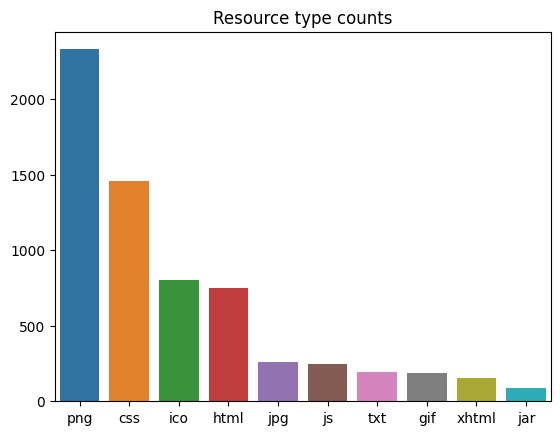

In [15]:
x = [res_type for (res_type, count) in resource_type_counts]
y = [count for (res_type, count) in resource_type_counts]

sns.barplot(x, y)
plt.title("Resource type counts")
plt.show()

4. Narysować mapę z lokalizacjami klientów.


In [17]:
pattern_ip = "[(\d\.)]+"

ips = (data
    .map(lambda log: reg.search(pattern_ip, log).group(0))
    .distinct()
    .collect()
)

ips[:25]

['83.149.9.216',
 '110.136.166.128',
 '46.105.14.53',
 '123.125.71.35',
 '200.49.190.100',
 '67.214.178.190',
 '207.241.237.220',
 '207.241.237.227',
 '207.241.237.228',
 '218.30.103.62',
 '71.212.224.97',
 '86.1.76.62',
 '107.170.41.69',
 '208.115.111.72',
 '174.37.205.76',
 '134.76.249.10',
 '123.125.71.117',
 '65.19.138.34',
 '5.102.173.71',
 '187.45.193.158',
 '36.38.8.174',
 '71.207.12.53',
 '220.241.45.142',
 '146.1.1.2',
 '178.255.215.83']

In [18]:
access_token = "e2129d74bb4a2b"
ipinfo_handler = ipinfo.getHandler(access_token=access_token)

ipinfo_response = ipinfo_handler.getBatchDetails(ips)
locations = [
    details["loc"].split(",") 
    for details in ipinfo_response.values()
]

locations = [(float(lat), float(long)) for lat, long in locations]
locations[:5]

[(55.7522, 37.6156),
 (48.5839, 7.7455),
 (39.9075, 116.3972),
 (40.7143, -74.006),
 (37.7749, -122.4194)]

In [26]:
def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

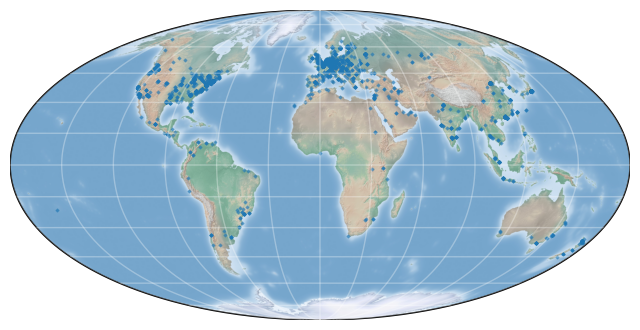

In [36]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='moll', resolution=None,
            lat_0=0, lon_0=0)
draw_map(m)
lats = [lat for (lat, long) in locations]
longs = [long for (lat, long) in locations]

m.scatter(longs, lats, latlon=True,
          cmap='Reds', marker='D', alpha=0.5,  s=2)

5. Oszacować jaki procent ruchu generują boty. Porównać co najmniej 2 sposoby oszacowania.

In [37]:
pattern_user_agent = "\"(.*?)\""
bots_set = {"Googlebot", "AskJeeves", "Digger", "Lycos", "msnbot",
    "Inktomi Slurp", "Yahoo", "Nutch", "bingbot", "BingPreview",
    "Mediapartners-Google", "proximic", "AhrefsBot", "AdsBot-Google",
    "Ezooms", "AddThis.com", "facebookexternalhit", "MetaURI",
    "Feedfetcher-Google", "PaperLiBot", "TweetmemeBot", "Sogou web spider",
    "GoogleProducer", "RockmeltEmbedder", "ShareThisFetcher", "YandexBot",
    "rogerbot-crawler", "ShowyouBot", "Baiduspider", "Sosospider", "Exabot"
}

bot_count = (data
    .filter(lambda log: any(bot in log for bot in bots_set))
    .count()
)

bot_perc = 100 * (bot_count / data.count())
print(f"Procent ruchu generowanego przez boty: {bot_perc:.2f}%")

Procent ruchu generowanego przez boty: 13.47%
